# Part One: K-fold Cross Validation

The challenge of training machine learning models is to be able to make accurate predictions on previously unseen real-world data in spite of the fact that we only have a finite training dataset to learn from. 

One way of validating our model's quality-of-fit and avoiding overfitting/underfitting, is to use the test_train_split method like we did in the code challenge. With this method, the randomly selected test dataset can be used to evaluate how our model performs on data that it has not yet seen in the training process. However, there are downsides to this approach:

*   We lose a valuable portion of data that we would prefer to be able to train on to serve as the test dataset. We would prefer to have both the testing and training datasets be as large as possible.
*   With small datasets, measures of our model's quality using the test_train_split method often have a high variance. (We saw this behavior when we changed the random seed in the code challenge)

We can reduce the severity of both of these drawbacks by using what is called K-fold Cross Validation:

[Short Video Explaining K-Fold Cross Validation](https://www.youtube.com/watch?v=TIgfjmp-4BA)

[How to Implement K-Fold Cross Validation on the Pima Indians Diabetes dataset](https://machinelearningmastery.com/evaluate-performance-machine-learning-algorithms-python-using-resampling/)

## DO THIS:

**1)** Train a logistic regression model on the titanic dataset predicting survivors first using a 20-80% test_train_split and print the accuracy of your model using 5 different random seeds.

**2)** Use 5-fold Cross Validation on the titanic dataset. Print out the accuracies from each of the 5 folds of the cross validation, then print the final mean and standard deviation of those cross validation accuracies. How do the accuracies on each of the inidvidual folds compare to the accuracies of the test_train_split approach? Is the variance in accuracies of the cross-validation approach higher or lower than the variance of the test_train_split approach? 

**3)** Try using 3-fold Cross Validation as well as 10-fold cross validation. How does the number of folds in the cross-validation process affect the outcome? How many folds should be used?

---
I would give you more boilerplate code here, but I don't want to make it too easy. The articles linked above should be sufficient for this purpose.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

The following is a script that I've used multiple times to load and preprocess my Titanic data. It encodes the ordered categorical variables as integers, one-hot encodes `Embarked`, fills missing values with the most frequent value for categorical variables and the median for the continuous variables, and drops duplicate rows and redundant columns.

In [2]:
def fill_mixed_median_mode(dataframe, medians=list()):
    """ Fill missing values with median for specified column, otherwise mode
    
    Args:
        dataframe (pandas.core.frame.DataFrame): rows of observations of features
        medians (list): columns to fill missing values with median instead of mode
        
    Returns:
        dataframe with no missing values
    """
    
    
    null = dataframe.isnull().any()
    null_cols = list(null[null].index)
    
    fill = pd.Series([data[c].median() if c in medians else data[c].mode()[0]
                     for c in null_cols], index=null_cols)
    
    dataframe[null_cols] = dataframe[null_cols].fillna(fill)
    return dataframe

data = sns.load_dataset('titanic')
data = data.drop(['alive','adult_male','who','class','embark_town', 'deck'], axis=1)
data = data.drop_duplicates()

data_f = fill_mixed_median_mode(data, ['age', 'fare'])

for label in ['embarked','sex', 'alone']:
    data_f[label] = LabelEncoder().fit_transform(data_f[label])

embarked_one_hot = OneHotEncoder().fit_transform(data_f[['embarked']]).toarray()
embarked = pd.DataFrame(embarked_one_hot, 
                        columns=['Southampton', 'Cherbourg', 'Queenstown'], 
                        dtype=np.int64)

data_f = data_f.reset_index(drop=True)
data_enc = data_f.join([embarked])
data_enc = data_enc.drop(['embarked'], axis=1)

data_enc.head()

,survived,pclass,sex,age,sibsp,parch,fare,alone,Southampton,Cherbourg,Queenstown
0,0,3,1,22.0,1,0,7.2500,0,0,0,1
1,1,1,0,38.0,1,0,71.2833,0,1,0,0
2,1,3,0,26.0,0,0,7.9250,1,0,0,1
3,1,1,0,35.0,1,0,53.1000,0,0,0,1
4,0,3,1,35.0,0,0,8.0500,1,0,0,1


## Train Test Split

In [0]:
X = data_enc.drop('survived', axis=1)
Y = data_enc[['survived']]

In [4]:
seeds = [10, 21, 41, 42, 66]

for seed in seeds:
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y.values.ravel(), 
                                                        test_size=0.2, random_state=seed)
    
    model = LogisticRegression()
    model.fit(X_train, Y_train)
    
    accuracy = model.score(X_test, Y_test)
    
    print('Random Seed: {}, Accuracy: {:.1f}%'.format(seed, accuracy*100))

Random Seed: 10, Accuracy: 75.0%
Random Seed: 21, Accuracy: 80.1%
Random Seed: 41, Accuracy: 78.2%
Random Seed: 42, Accuracy: 79.5%
Random Seed: 66, Accuracy: 78.8%


## 5-fold Cross Validation

In [5]:
kf = KFold(n_splits=5, random_state=41)
kf.get_n_splits(X)

validation_accuracy = 0
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    
    model = LogisticRegression()
    model.fit(X_train, Y_train)
    
    accuracy = model.score(X_test, Y_test.values.ravel())
    validation_accuracy += accuracy
    
validation_accuracy /= 5

print('Mean Validation Accuracy Across 5 Folds: {:.1f}%'.format(validation_accuracy*100))

Mean Validation Accuracy Across 5 Folds: 76.2%


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Trying Multiple Folds

I will wrap the above code in a function so that it is straightforward to reuse it for differing amounts of folds.

In [0]:
def kfold_accuracy(X, Y, k=5, random_state=41):
    kf = KFold(n_splits=k, random_state=random_state)
    kf.get_n_splits(X)

    validation_accuracy = 0
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

        model = LogisticRegression()
        model.fit(X_train, Y_train)

        accuracy = model.score(X_test, Y_test.values.ravel())
        validation_accuracy += accuracy

    return validation_accuracy / k

In [0]:
folds = [2, 3, 4, 5, 6, 7, 8, 9, 10]
accuracies = [kfold_accuracy(X, Y, k) for k in folds]

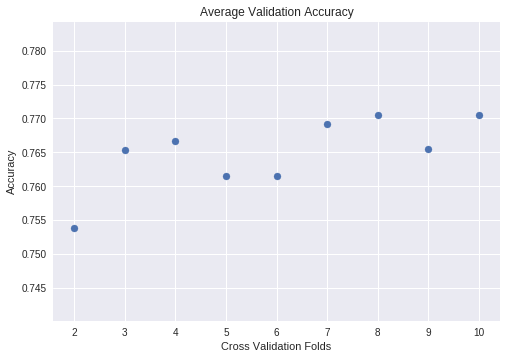

In [8]:
fig, ax = plt.subplots()
ax.scatter(folds, accuracies)
ax.set(title='Average Validation Accuracy', 
       xlabel='Cross Validation Folds', 
       ylabel='Accuracy');

There is a noticeable jump in validation accuracy when going from using 2 to 3 folds. As the number of folds is increased, the model is trained on a larger proportion of the data, and so should benefit from this up to a certain point.

The other trend is that as the folds increase, the proportion of the data used for validation decreases, and thus becomes less accurate as a statistical estimate of the model's ability to generalize to unseen data.

One way to determine the number of folds to use is to also include the variance of the validation accuracy. This can then be used to understand how reliable of an estimate the average validation accuracy across folds then is. One can then construct selection criteria based off of this. For example, selecting a value for k such that no greater value has an estimate of the accuracy which is one standard deviation above the accuracy at k, using the standard deviation for the higher value.

Of course, the choice to use 1 standard deviation as a sort of confidence interval is arbitrary. Better, more motivated choices likely exist.

In [0]:
def kfold_accuracy_with_std(X, Y, k=5, random_state=41):
    kf = KFold(n_splits=k, random_state=random_state)
    kf.get_n_splits(X)

    accuracies = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

        model = LogisticRegression()
        model.fit(X_train, Y_train)

        accuracy = model.score(X_test, Y_test.values.ravel())
        accuracies.append(accuracy)

    return np.mean(accuracies), np.std(accuracies)

In [0]:
accuracies = []
stds = []
for k in folds:
    acc, std = kfold_accuracy_with_std(X, Y, k)
    accuracies.append(acc)
    stds.append(std)

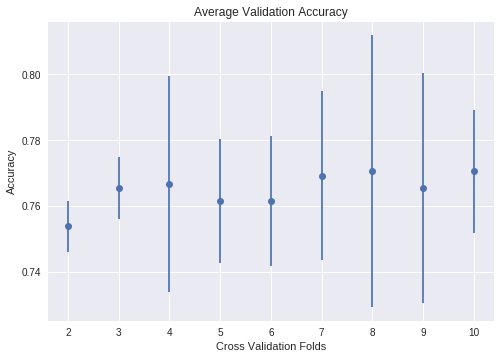

In [11]:
fig, ax = plt.subplots()
ax.errorbar(folds, accuracies, yerr=stds, fmt='o')
ax.set(title='Average Validation Accuracy', 
       xlabel='Cross Validation Folds', 
       ylabel='Accuracy');

Using the example selection criterion desribed above, I would select 3 folds, since one standard deviation below its accuracy estimate is still greater than the acuracy estimate for 2 folds.

# Part Two: Hyperparameter Tuning

An important technique for improving the accuracy of a machine learning model is to undertake a process known as Hyperparameter Tuning or Hyperparameter Optimization. In order to understand this process, we first need to understand the difference between a model parameter and a model hyperparameter. 

### What is a model parameter?

A model parameter is a value that is generated by fitting our model to training data and is key to generating predictions with that model. They are **internal** to our model and we often are trying to estimate them as best as possible when we train the algorithm. 

For example, the parameters of a linear regression model would be its intercept value as well as the coefficient values on each of the X variables. Estimates of these crucial values (parameters) are obtained by fitting to the training data, perfectly define the model, are internal to the model, and are key to generating predictions. They are model parameters in every sense. 

### What is a model hyperparameter?

Hyperparameters are values that are key to how well our algorithm runs, yet are **external** to our model and cannot be estimated from the training process. They are more like settings for our algorithm which must be designated before it is run and impact its performance. Here is some further reading:

[Hyperparamters explanation on Quora](https://www.quora.com/What-are-hyperparameters-in-machine-learning)

[Jason Brownlee Article on the difference between Parameters and Hyperparameters](https://machinelearningmastery.com/difference-between-a-parameter-and-a-hyperparameter/)

### How do we find the best hyperparameters?

Since we can't learn the best hyperparameters for our model from the data, we essentially just pick values and see which ones lead to the highest accuracy. This can be a tedious and complex process especially for certain models like neural networks which can have dozens of hyperparameters. We will get you familiar with the process using a more simple logistic regression model. 

### How do you know what hyperparameters exist for your particular model? 

Most models/libraries have default hyperparameters that will be used if we don't specify them. In the model selection process you might try out multiple models on a dataset and see which one gets you the highest out-of-the-box performance, (using the default hyperparameters) and then pick a couple of the highest performing algorithms and attempt hyperparameter tuning on them to compare how different models benefit from this process. Once you have narrowed down the models that you would like to tune, a quick google search can tell you what hyperparameters exist for that algorithm. 

Often you can learn about potential hyperparameters by looking at the documentation for a given algorithm in a library, here's the documentation for sklearn's logistic regression, see if you can spot the hyperparameters:

[scikit-learn logistic regression docs](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html)



## DO THIS: 

Lets hyperparameter tune our **titanic** predictions using 5-fold cross validation to compare the accuracy of our tuned models. 

### Manual Hyperparameter Tuning:

For our assignment today we are going to tune the 'C value' also known as the 'regularization strength' of our logistic regression as well as 'penalty' of our logistic regression algorithm.

Read up on the regularlization strength and penalty of a logistic regression function. What might be some good values to test out? Hint: Look at the parameter definitions on the sci-kit learn logistic regression documentation. 

[scikit-learn logistic regression docs](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

[Regularization in Logistic Regression](https://www.kdnuggets.com/2016/06/regularization-logistic-regression.html)

Fit your model 5 different times using 5 different C values of your choosing. Which value gives the highest accuracy? 

There are only two penalty values that we can use. Evaluate the model two more times using each penalty once. Which penalty gives the highest accuracy?

In [12]:
# The sample code below uses the Pima Indans Diabetes Dataset. 
# Here we are setting the C value hyperparameter to 1 and the penalty hyperparameter to "l1". 
# You can designate your hyperparameters in a similar fashion.

import pandas
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = pandas.read_csv(url, names=names)
array = dataframe.values
X = array[:,0:8]
Y = array[:,8]
num_instances = len(X)
seed = 7
kfold = model_selection.KFold(n_splits=5, random_state=seed)
model = LogisticRegression(C=1, penalty='l1') ##### This is the important line
results = model_selection.cross_val_score(model, X, Y, cv=kfold)
print(results)

[0.75974026 0.72727273 0.76623377 0.83006536 0.76470588]


### 1) Grid-Search Hyperparameter Tuning:

Imagine that your algorithm has 12 different potential hyperparameters and each them can take on 5 different values. Lets say that it takes your laptop 4 seconds to fit each fold of cross validation. For each 5-fold cross-validation it would then take 20 seconds to fit your model and get an accuracy reading reported back. Now imagine that you want to test every possible combination of hyperparameters on your algorithm to get the absolute highest accuracy. You can see how this might become exceedingly tedious and time-consuming to perform by hand. Some hyperparameters (like the C value) have much more than 5 potential values, making hyperparameter tuning a huge task. 

It is for this reason that more advanced optimization techniques exist, one of which we will be exploring today called GridSearch.

### What does GridSearch do?

GridSearch takes a dictionary of all of the different hyperparameters that you want to test, and then feeds all of the different combinations through the algorithm for you and then reports back to you which one had the highest accuracy. Pretty slick right? 

Here is some boilerplate code you can reference to create your implementations:

[Chris Albon Logistic Regression sklearn Hyperparameter Tuning with GridSearch](https://chrisalbon.com/machine_learning/model_selection/hyperparameter_tuning_using_grid_search/)

In [0]:
# These import statements might be useful to you. 
from sklearn.model_selection import GridSearchCV

In [0]:
# Create logistic regression object
model = LogisticRegression()

In [0]:
# Create a list of all of the different penalty values that you want to test and save them to a variable called 'penalty'
penalty = ['l1', 'l2']

In [0]:
# Create a list of all of the different C values that you want to test and save them to a variable called 'C'
C = np.logspace(-1, 3, 5)

In [17]:
# Now that you have two lists each holding the different values that you want test, use the dict() function to combine them into a dictionary. 
# Save your new dictionary to the variable 'hyperparameters'
# Print out the dictionary if you're curious as to what it euds up looking like.

hyperparameters = dict(C=C, penalty=penalty)
print(hyperparameters)

{'penalty': ['l1', 'l2'], 'C': array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])}


In [0]:
# Fit your model using gridsearch

clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

In [19]:
# Print the best penalty and C value from best_model.best_estimator_.get_params()

best_model = clf.fit(X, Y)
best_params = best_model.best_estimator_.get_params()

print('Best penalty: {}, Best C: {}'.format(best_params['penalty'], best_params['C']))

Best penalty: l2, Best C: 100.0


In [20]:
# Print out all of the different combinations of your grid search values and their corresponding accuracies.
# https://stackoverflow.com/questions/22155953/how-to-print-out-an-accuracy-score-for-each-combination-within-gridsearch

params, mean, std = [clf.cv_results_[key] for key in ['params', 'mean_test_score', 'std_test_score']]
pty = [p['penalty'] for p in params]
c = [p['C'] for p in params]

gridsearch = pd.DataFrame([pd.Series(x) for x in [pty, c, mean, std]]).T
gridsearch.columns = ['Penalty', 'C', 'Accuracy: Mean', 'Accuracy: Standard Deviation']

gridsearch

,Penalty,C,Accuracy: Mean,Accuracy: Standard Deviation
0,l1,0.1,0.759115,0.022952
1,l2,0.1,0.727865,0.0170129
2,l1,1,0.766927,0.0235538
3,l2,1,0.768229,0.0186303
4,l1,10,0.770833,0.0221773
5,l2,10,0.766927,0.0232765
6,l1,100,0.770833,0.0247179
7,l2,100,0.772135,0.0245323
8,l1,1000,0.770833,0.0247179
9,l2,1000,0.770833,0.0247179


What hyperparameters give you the highest accuracy? Keep on testing diferent values and report the hyperparameters that give you the highest accuracy.

Since performing a grid search with different orders of magnitude for C produced 100 as the best value, I will search more exhaustively around this.

In [0]:
C = np.linspace(1, 150)
hyperparameters = dict(C=C, penalty=penalty)
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)
best_model = clf.fit(X, Y)

In [43]:
best_params = best_model.best_estimator_.get_params()
print('Best penalty: {}, Best C: {}'.format(best_params['penalty'], best_params['C']))

Best penalty: l1, Best C: 19.2448979592


The C value found is still quite high, indicating that regularization hurts the performance of the model. This is unsurprising, since logistic regression as a model has very low variance, and penalizing its parameters values will lead to underfitting.

# Stretch Goals:

Explore more advanced automated approaches to hyperparameter tuning. Try and implemenet a random search approach: 

[Random Search Hyperparameter Tuning](https://machinelearningmastery.com/how-to-tune-algorithm-parameters-with-scikit-learn/)

Then try a Bayesian Optimization Approach:

[Bayesian Optimization](https://thuijskens.github.io/2016/12/29/bayesian-optimisation/)

[scikit-optimize](https://scikit-optimize.github.io/notebooks/bayesian-optimization.html)

[optunity](http://optunity.readthedocs.io/en/latest/notebooks/notebooks/sklearn-automated-classification.html)

You could also try writing a blog post to show how well you understand Cross Validation or Hyperparameter Tuning, both are key concepts to practicing machine learning and would be valuable to demonstrate proficency in.


## Random Search Hyperparameter Tuning

In [0]:
from sklearn.model_selection import RandomizedSearchCV

In [0]:
C = np.logspace(-1, 3, 1000)
penalty = ['l1', 'l2']
hyperparameters = dict(C=C, penalty=penalty)

In [0]:
model = LogisticRegression()

In [50]:
clf = RandomizedSearchCV(model, hyperparameters, n_iter=100, random_state=41)
clf.fit(X, Y)
print(clf.best_params_)

{'penalty': 'l2', 'C': 1.9828839491270713}


Random search finds a much lower C value. This is potentially due to the fact that the distribution created by `np.logspace` is skewed. I will repeat the analysis with `np.linspace`.

In [52]:
C = np.linspace(1, 1000)
penalty = ['l1', 'l2']
hyperparameters = dict(C=C, penalty=penalty)

clf = RandomizedSearchCV(model, hyperparameters, n_iter=100, random_state=41)
clf.fit(X, Y)
print(clf.best_params_)

{'penalty': 'l1', 'C': 21.387755102040817}


Sure enough, this produces results more consistent with what was obtained with the grid search. This demonstrates the fact that a random search samples from the distributions provided, instead of exhaustively searching through their range. Thus, the shape and skew of the distributions influence the result.

## Bayesian Optimization

In [0]:
# https://github.com/thuijskens/bayesian-optimization/blob/master/python/gp.py

import sklearn.gaussian_process as gp

from sklearn.model_selection import cross_val_score
from scipy.stats import norm
from scipy.optimize import minimize

def expected_improvement(x, gaussian_process, evaluated_loss, greater_is_better=False, n_params=1):
    """ expected_improvement
    Expected improvement acquisition function.
    Arguments:
    ----------
        x: array-like, shape = [n_samples, n_hyperparams]
            The point for which the expected improvement needs to be computed.
        gaussian_process: GaussianProcessRegressor object.
            Gaussian process trained on previously evaluated hyperparameters.
        evaluated_loss: Numpy array.
            Numpy array that contains the values off the loss function for the previously
            evaluated hyperparameters.
        greater_is_better: Boolean.
            Boolean flag that indicates whether the loss function is to be maximised or minimised.
        n_params: int.
            Dimension of the hyperparameter space.
    """

    x_to_predict = x.reshape(-1, n_params)

    mu, sigma = gaussian_process.predict(x_to_predict, return_std=True)

    if greater_is_better:
        loss_optimum = np.max(evaluated_loss)
    else:
        loss_optimum = np.min(evaluated_loss)

    scaling_factor = (-1) ** (not greater_is_better)

    # In case sigma equals zero
    with np.errstate(divide='ignore'):
        Z = scaling_factor * (mu - loss_optimum) / sigma
        expected_improvement = scaling_factor * (mu - loss_optimum) * norm.cdf(Z) + sigma * norm.pdf(Z)
        expected_improvement[sigma == 0.0] == 0.0

    return -1 * expected_improvement


def sample_next_hyperparameter(acquisition_func, gaussian_process, evaluated_loss, greater_is_better=False,
                               bounds=(0, 10), n_restarts=25):
    """ sample_next_hyperparameter
    Proposes the next hyperparameter to sample the loss function for.
    Arguments:
    ----------
        acquisition_func: function.
            Acquisition function to optimise.
        gaussian_process: GaussianProcessRegressor object.
            Gaussian process trained on previously evaluated hyperparameters.
        evaluated_loss: array-like, shape = [n_obs,]
            Numpy array that contains the values off the loss function for the previously
            evaluated hyperparameters.
        greater_is_better: Boolean.
            Boolean flag that indicates whether the loss function is to be maximised or minimised.
        bounds: Tuple.
            Bounds for the L-BFGS optimiser.
        n_restarts: integer.
            Number of times to run the minimiser with different starting points.
    """
    best_x = None
    best_acquisition_value = 1
    n_params = bounds.shape[0]

    for starting_point in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, n_params)):

        res = minimize(fun=acquisition_func,
                       x0=starting_point.reshape(1, -1),
                       bounds=bounds,
                       method='L-BFGS-B',
                       args=(gaussian_process, evaluated_loss, greater_is_better, n_params))

        if res.fun < best_acquisition_value:
            best_acquisition_value = res.fun
            best_x = res.x

    return best_x


def bayesian_optimisation(n_iters, sample_loss, bounds, x0=None, n_pre_samples=10,
                          gp_params=None, random_search=False, alpha=1e-5, epsilon=1e-7):
    """ bayesian_optimisation
    Uses Gaussian Processes to optimise the loss function `sample_loss`.
    Arguments:
    ----------
        n_iters: integer.
            Number of iterations to run the search algorithm.
        sample_loss: function.
            Function to be optimised.
        bounds: array-like, shape = [n_params, 2].
            Lower and upper bounds on the parameters of the function `sample_loss`.
        x0: array-like, shape = [n_pre_samples, n_params].
            Array of initial points to sample the loss function for. If None, randomly
            samples from the loss function.
        n_pre_samples: integer.
            If x0 is None, samples `n_pre_samples` initial points from the loss function.
        gp_params: dictionary.
            Dictionary of parameters to pass on to the underlying Gaussian Process.
        random_search: integer.
            Flag that indicates whether to perform random search or L-BFGS-B optimisation
            over the acquisition function.
        alpha: double.
            Variance of the error term of the GP.
        epsilon: double.
            Precision tolerance for floats.
    """

    x_list = []
    y_list = []

    n_params = bounds.shape[0]

    if x0 is None:
        for params in np.random.uniform(bounds[:, 0], bounds[:, 1], (n_pre_samples, bounds.shape[0])):
            x_list.append(params)
            y_list.append(sample_loss(params))
    else:
        for params in x0:
            x_list.append(params)
            y_list.append(sample_loss(params))

    xp = np.array(x_list)
    yp = np.array(y_list)

    # Create the GP
    if gp_params is not None:
        model = gp.GaussianProcessRegressor(**gp_params)
    else:
        kernel = gp.kernels.Matern()
        model = gp.GaussianProcessRegressor(kernel=kernel,
                                            alpha=alpha,
                                            n_restarts_optimizer=10,
                                            normalize_y=True)

    for n in range(n_iters):

        model.fit(xp, yp)

        # Sample next hyperparameter
        if random_search:
            x_random = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(random_search, n_params))
            ei = -1 * expected_improvement(x_random, model, yp, greater_is_better=True, n_params=n_params)
            next_sample = x_random[np.argmax(ei), :]
        else:
            next_sample = sample_next_hyperparameter(expected_improvement, model, yp, greater_is_better=True, bounds=bounds, n_restarts=100)

        # Duplicates will break the GP. In case of a duplicate, we will randomly sample a next query point.
        if np.any(np.abs(next_sample - xp) <= epsilon):
            next_sample = np.random.uniform(bounds[:, 0], bounds[:, 1], bounds.shape[0])

        # Sample loss for new set of parameters
        cv_score = sample_loss(next_sample)

        # Update lists
        x_list.append(next_sample)
        y_list.append(cv_score)

        # Update xp and yp
        xp = np.array(x_list)
        yp = np.array(y_list)

    return xp, yp

Because `penalty` is not a hyperparameter with continuous values, I will have to associate intervals with each individual type of penalty. The value for penalty found through Bayesian optimization can then be interpreted as a measure of certainty that the penalty is `l2`. The discontinuity introduced may hurt the performance of the optimizer, but since `C` is really the hyperparameter of interest, I am willing to accept this.

In [0]:
def sample_loss(params):
    C = params[0]
    penalty = 'l1' if params[1] < (bounds[1,1]//2) else 'l2'
    
    model = LogisticRegression(C=C, penalty=penalty)
    
    return cross_val_score(model,
                           X=X,
                           y=Y,
                           cv=5).mean()

In [55]:
n_iters = 10
bounds = np.array([[0, 10], [0, 1]])
hyperparameters, scores = bayesian_optimisation(n_iters, sample_loss, bounds)

/usr/local/lib/python2.7/dist-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([1.39546981e-05]), 'nit': 7, 'funcalls': 51}
  " state: %s" % convergence_dict)


In [56]:
best_ix = np.argmax(scores)
print(best_ix)
best_C = hyperparameters[best_ix,0]
best_penalty = 'l1' if hyperparameters[best_ix,1] < 0.5 else 'l2'
print('Best penalty: {}, Best C: {}'.format(best_penalty, best_C))

8
Best penalty: l1, Best C: 5.71889177486


The best hyperparameters were not found over the course of the 10 Bayesian optimization iterations, but were from the 10 initial samples. I will try searching only for a value of C, with `l1` as the penalty.

In [0]:
def sample_loss(params):
    C = params[0]
    
    model = LogisticRegression(C=C, penalty='l1')
    
    return cross_val_score(model,
                           X=X,
                           y=Y,
                           cv=5).mean()

In [63]:
n_iters = 10
bounds = np.array([[0, 20]])
hyperparameters, scores = bayesian_optimisation(n_iters, sample_loss, bounds, n_pre_samples=5)

best_ix = np.argmax(scores)
print(best_ix)
best_C = hyperparameters[best_ix,0]
print('Best C: {}'.format(best_C))

5
Best C: 19.316149877


Bayesian optimization finds the best hyperparameter on its first iteration. This indicates that the presamples allowed for an accurate estimate of the loss as a function of the hyperparameters, but that taking further samples biased this estimate towards the neighborhood of these new samples.